Import all dependancies

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

# TODO: Handle relative paths correctly so we can all run it independantly and add to the readme where the dataset needs to be stored
dataset_path = r"C:\Users\chris\Desktop\University\Code\ComputerVision\ForestNetDataset"

Load the dataset into memory

In [2]:
# Join the directory with each CSV filename.
test_path = os.path.join(dataset_path, "test.csv")
train_path = os.path.join(dataset_path, "train.csv")
validation_path = os.path.join(dataset_path, "val.csv")

# Read the CSV files into pandas DataFrames.
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(validation_path)

# Create a mapping from the string labels to integers based on the training data.
labels = sorted(train_df["merged_label"].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}
print("Label mapping:", label_to_index)


# FOR MODEL DEVELOPMENT JUST USE THE FIRST 128 SAMPLES FROM THE TRAINING SET
# train_df = train_df.head(128)

Label mapping: {'Grassland shrubland': 0, 'Other': 1, 'Plantation': 2, 'Smallholder agriculture': 3}


Balance the training set

In [3]:
# Print counts per class before oversampling
print("Counts per class before oversampling:")
print(train_df["merged_label"].value_counts())

# Get the maximum count among classes
max_count = train_df["merged_label"].value_counts().max()

# For each class, sample max_count examples with replacement.
balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(
    lambda x: x.sample(max_count, replace=True, random_state=42)
).reset_index(drop=True)

print("After oversampling, counts per class:")
print(balanced_train_df["merged_label"].value_counts())
train_df = balanced_train_df

Counts per class before oversampling:
merged_label
Plantation                 686
Smallholder agriculture    556
Other                      231
Grassland shrubland        143
Name: count, dtype: int64
After oversampling, counts per class:
merged_label
Grassland shrubland        686
Other                      686
Plantation                 686
Smallholder agriculture    686
Name: count, dtype: int64


C:\Users\chris\AppData\Local\Temp\ipykernel_33476\1046957484.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(


Define DataLoaders for the training and test set

In [4]:

# This class implements the function __getitem__ which means it can be passed into the DataLoader class from pytorch 
# which makes the batch processing much more seamless.
class ForestNetDataset(Dataset):
    def __init__(self, df, dataset_path, transform=None, label_map=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing the image paths and labels.
            dataset_path (str): The base directory for the images.
            transform (callable, optional): A function/transform to apply to the images.
            label_map (dict, optional): Mapping from label names to integers.
        """
        self.df = df
        self.dataset_path = dataset_path
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            image_rel_path = row["example_path"] + "/images/visible/composite.png"
            image_path = os.path.join(self.dataset_path, image_rel_path)
            # Debug: print the image_path to see if it looks correct
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = row["merged_label"]
            if self.label_map is not None:
                label = self.label_map[label]
            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx} from path {image_path}: {e}")
            raise e


# --- Image Transforms ---
# Resize images to 322x322, convert them to tensors, and normalize.
transform = transforms.Compose([
    transforms.Resize((322, 322)),
    transforms.ToTensor(),

    # TODO: Look into calculating these values for our dataset. It probably has a lot more green than other
    # datasets.
    # These normalization values are typical for natural images.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Create Datasets and DataLoaders ---
train_dataset = ForestNetDataset(train_df, dataset_path, transform=transform, label_map=label_to_index)
test_dataset = ForestNetDataset(test_df, dataset_path, transform=transform, label_map=label_to_index)
val_dataset = ForestNetDataset(val_df, dataset_path, transform=transform, label_map=label_to_index)


batch_size = 32
# TO DO: Experiment with different num_workers (I don't know what this does)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle= False, num_workers=0 )

Train and evaluate model

Old 256 by 256 model

In [53]:
# CNN with input images sized 256x256
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             # Convolutional Block 1: Input 3 x 256 x 256 -> Output 16 x 256 x 256, then maxpool to 16 x 128 x 128
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
#             # Convolutional Block 2: 16 x 128 x 128 -> 32 x 128 x 128, then maxpool to 32 x 64 x 64
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
#             # Convolutional Block 3: 32 x 64 x 64 -> 64 x 64 x 64, then maxpool to 64 x 32 x 32
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(64 * 32 * 32, 128),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )
        
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)  # Flatten the features for the classifier
#         x = self.classifier(x)
#         return x

In [5]:
# CNN for size 322 by 322 ie. the max shape of the images
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1: Input 3 x 322 x 322 -> Conv -> 16 x 322 x 322, then maxpool to 16 x 161 x 161
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 2: 16 x 161 x 161 -> Conv -> 32 x 161 x 161, then maxpool to 32 x 80 x 80
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 3: 32 x 80 x 80 -> Conv -> 64 x 80 x 80, then maxpool to 64 x 40 x 40
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Extra pooling to reduce feature map size from 40 x 40 to 20 x 20
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 20 * 20, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features for the classifier
        x = self.classifier(x)
        return x


# Assume the number of classes is determined by your label mapping:
num_classes = len(label_to_index)
model = SimpleCNN(num_classes)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Early stopping parameters
patience = 1
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training and Evaluation Loop
num_epochs = 20
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    epoch_start = time.time()  # Start time for the epoch
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()           # Zero the gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    training_losses.append(epoch_loss)

    # VALIDATION EVALUATION
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    validation_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f} Validation Loss: {epoch_val_loss:.4f}")
    
    # --- Early Stopping Check ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")
        if epochs_without_improvement >= patience:
            print("Validation loss has not improved for 5 consecutive epochs. Early stopping triggered.")
            break
    
    # UNCOMMENT IF YOU WANT TO EVALUATE THE TEST ACCURACY EVERY EPOCH
    # --- Evaluation ---
    # model.eval()
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for images, labels in test_loader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, preds = torch.max(outputs, 1)
    #         correct += (preds == labels).sum().item()
    #         total += labels.size(0)
    # accuracy = correct / total
    # print(f"Test Accuracy: {accuracy:.4f}")

    epoch_end = time.time()  # End time for the epoch
    epoch_duration = epoch_end - epoch_start
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_time_remaining = epoch_duration * remaining_epochs
    print(f"Epoch Time: {epoch_duration:.2f}s, Estimated time remaining: {estimated_time_remaining:.2f}s\n")

print("Training complete.")


Using device: cuda
Epoch 1/20, Training Loss: 1.3840 Validation Loss: 1.3676
Epoch Time: 37.94s, Estimated time remaining: 720.91s

Epoch 2/20, Training Loss: 1.3557 Validation Loss: 1.3342
Epoch Time: 29.92s, Estimated time remaining: 538.61s

Epoch 3/20, Training Loss: 1.3228 Validation Loss: 1.2890
Epoch Time: 45.08s, Estimated time remaining: 766.42s

Epoch 4/20, Training Loss: 1.2759 Validation Loss: 1.3119
No improvement for 1 epoch(s).
Validation loss has not improved for 5 consecutive epochs. Early stopping triggered.
Training complete.


Plot training losses

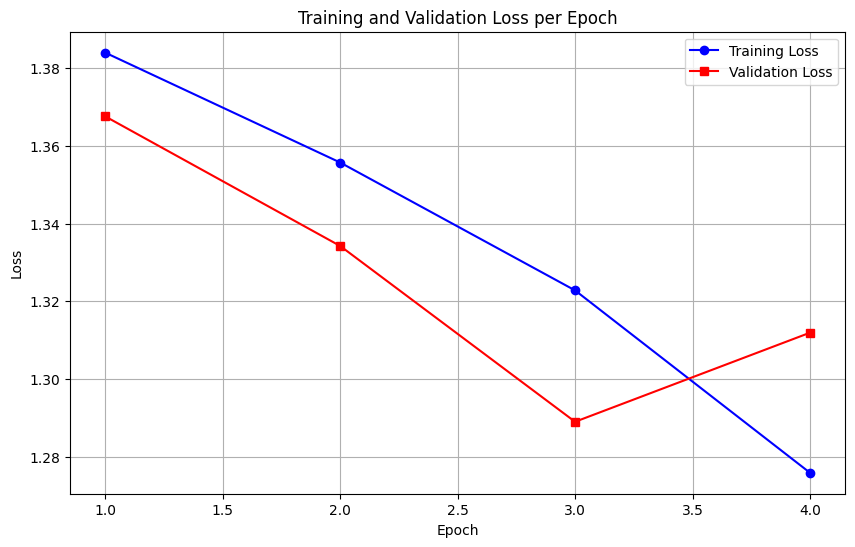

In [ ]:
epochs = range(1, len(training_losses) + 1)  # Create epoch numbers starting at 1

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, validation_losses, marker='s', linestyle='-', color='r', label='Validation Loss')
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.show()

Classification Report:
                         precision    recall  f1-score   support

    Grassland shrubland     0.2111    0.2468    0.2275        77
                  Other     0.2796    0.2453    0.2613       106
             Plantation     0.5227    0.5130    0.5178       269
Smallholder agriculture     0.4615    0.4722    0.4668       216

               accuracy                         0.4266       668
              macro avg     0.3687    0.3693    0.3684       668
           weighted avg     0.4284    0.4266    0.4272       668



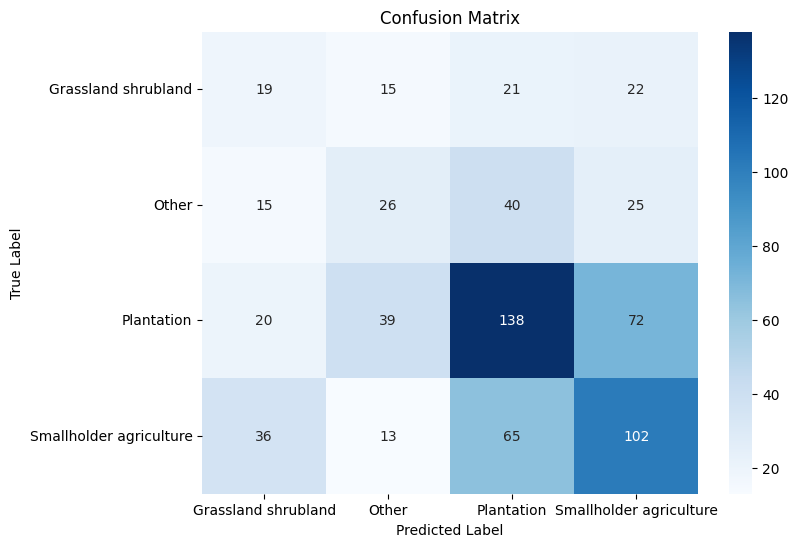

In [51]:
# Create a mapping to convert indices back to labels (for display purposes)
index_to_label = {v: k for k, v in label_to_index.items()}
target_names = [index_to_label[i] for i in range(num_classes)]

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report (includes precision, recall, and F1 score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Print confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap to display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()